# Computing, analyzing and comparing the radius of gyration and hydrodynamic radius in conformational ensembles of intrinsically disordered proteins
In this example we will be showing the procedure to calculate Rg and Rh as described in the paper "Computing, analyzing and comparing the radius of gyration and hydrodynamic radius in conformational ensembles of intrinsically disordered proteins"

Step by step we will show how to:
1. Calculate Rg and Rh from a file or a trajectory using MDtraj
2. Show how the input data should be structured for the BME software
3. Perform reweighing procedure with BME and select the parameter $\theta$
4. Plot figures in the paper
5. Runing  and setting the parameters for Pepsi-SAXS


#### Note! 
You should have installed the python modules: BME, MDtraj, seaborn, and matplotlib beforehand
and also made sure you set the correct path to the BME module.
more information on the BME code can be obtained at https://github.com/KULL-Centre/BME .
Furthermore, we will not provide detailed instructions on how to generate conformational ensembles, or calculate SAXS intensity profiles of the ensembles, the reader is expected to have done this beforehand.

In [1]:
### import modules 
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mdtraj as md
directory_to_bme = os.getcwd()[:-8]
sys.path.append(directory_to_bme)
import bme_reweight as bme
from uncertainties import ufloat

# 1 Calculating Rg and Rh
Now that we have loaded all the required modules, we can load a trajetory in MDtraj and calculate the Rg for each frame. The ensemble we load here, consist of 32000 frames sampled with Campari and described in main paper as Ensemble 1. 
We use Equation 3 in the main text to convert Rg values to Rh. 
Eq. 3 is parameterized using C-alpha atoms, so we only select the C-alpha atoms before converting.

We do all our calculation in  angstroms, since the parameters in Eq. 3 are in angstroms.


### Due to its size, we do not provide the trajectory in the Github repository. This is the code that we used to  generate the Rg values from the trajectory (which are read below). 

In [2]:
###  MDtraj loading trajectory and calculating Rg  
#traj = md.load("Ensemble.trr",top="structure.pdb") # Load trajectory and structure file
#CA_atoms = traj.topology.select('name CA')         # Selecting C-alpha atoms 
#traj.atom_slice(CA_atoms, inplace=True)
#rg = md.compute_rg(traj)                          
  
#Rg = np.reshape(np.array(rg*10),[-1, 1])           # Converting Rg from nm to Angstrom
#print Rg
#np.savetxt('Rg_calc.dat', rg)                      # Saves Rg values to the file "Rg_calc.dat"

We instead load Rg values from a file we pre calculated using the method above:

In [3]:
traj = md.load('../data/structure.pdb') #just used to get the number of residues                
Rg = np.loadtxt('../data/calc_Rg.txt')
print(Rg)

[26.05150339 27.39512119 22.13320178 ... 16.81065577 16.88125215
 17.07489347]


We now calculate Rh for each frame, using equation 3 from Nygaard et al.
and print the ensemble average Rg and Rh of the trajectory.
We futher calculate 1/Rh and I(Rh) for use in BME reweighting.


In [4]:
# Number of amino acids in protein
N = traj.n_residues

# Function for Rh, 1/Rh and I_Rh  calculation
def getRh(rg,N):
    # Parameters fitted in Nygaard et al.
    a1=0.216
    a2=4.06
    a3=0.821
    return (rg)/((a1*(rg-a2*N**(0.33)))/(N**(0.60)-N**(0.33))+a3)

def inversRh(rh):
    return 1./rh


def getIRh(rh):
    return np.exp(-1./rh)


# Rh calculation   
Rh = getRh(Rg,N)

# 1/Rh calculation
Rh_inv = inversRh(Rh)


# I_Rh calculation   
I_Rh = getIRh(Rh)

# Print the ensemble average Rg and Rh
print('Initial <Rg^2>^1/2: {:.2f},  Initial <1/Rh>^-1: {:.6f}'.format(np.sqrt(np.mean(Rg*Rg)),np.mean(1/Rh)**(-1)))
print('Initial <Rg>:       {:.2f},  Initial <Rh>:      {:.6f}'.format((np.mean(Rg)),np.mean(Rh)))
print('Initial <Rh> = -1/log(<IRh>):      {:.6f}'.format(-1./np.log(np.mean(I_Rh))))

# Save and structure 1/Rh values for BME input file 
with open('calc_Rh_inv.txt', 'w') as program:
    for (number, line) in enumerate(Rh_inv):
        program.write('%d  %s\n' % (number + 1, line))
        
# Save and structure I_Rh values for BME input file 
with open('calc_Irh.txt', 'w') as program:
    for (number, line) in enumerate(I_Rh):
        program.write('%d  %s\n' % (number + 1, line))

Initial <Rg^2>^1/2: 19.94,  Initial <1/Rh>^-1: 22.346481
Initial <Rg>:       19.41,  Initial <Rh>:      22.603242
Initial <Rh> = -1/log(<IRh>):      22.351721


As seen above there are diffrent ways of averaging the calculated values Rg and Rh.
Here we will reweight the enseble with intensity e.g `I(Rh)`, and thus only use the average method `(-1/log(Rh))` for Rh average. But we have also prepared BME input files for `1/Rh` and show the linear averging of Rh in case one will need that. 


In [23]:
### Experimental Rg and Rh and error values
# Rg_Exp =29.5
# Rg_error =1.5
# Rh_Exp =21.5
# Rh_error =1.1

Rg_Exp= ufloat(29.5, 1.5) 
Rh_Exp= ufloat(21.5, 1.1)
Rh_invs=1/Rh_Exp
I_rh=2.718**(-1./Rh_Exp)
print('Rh_inv = ',Rh_invs)
print('I_rh = ',I_rh)




Rh_inv =  0.0465+/-0.0024
I_rh =  0.9546+/-0.0023


# 2 BME Input data and how it is structured
In this example we will only be showing the input files for the SAXS input files. Incase you need to rewight with data such as RDC, NOE, jcouplings ect. please read the source code and paper for BME avalible at https://github.com/KULL-Centre/BME

Here we have already prepared the input files `exp_Irh.txt`, `exp_saxs.txt` and `calc_saxs.txt` for you.

BME takes two different types of input files for the reweighting: 

(I) An experimental file e.g `exp_saxs.txt`

(II) A file with calculated values of the same experimental observable e.g `calc_saxs.txt` 


We start by first looking at the format of the experimental file  :

In [17]:
#Experimental SAXS input file
%cat exp_saxs.txt 
saxs = '../data/exp_saxs.txt'

# DATA=SAXS PRIOR=GAUSS
0.023303 0.00087271 0.00004730
0.024413 0.00086838 0.00003923
0.025522 0.00084326 0.00004237
0.026632 0.00082876 0.00003437
0.027742 0.00081364 0.00002729
0.028851 0.00080704 0.00003766
0.029961 0.00079905 0.00003528
0.031071 0.00077278 0.00003294
0.032180 0.00075426 0.00003089
0.033290 0.00073401 0.00003041
0.034400 0.00072652 0.00002610
0.035509 0.00071407 0.00002938
0.036619 0.00069929 0.00002536
0.037729 0.00068648 0.00003313
0.038838 0.00066639 0.00002809
0.039948 0.00066899 0.00002364
0.041058 0.00063673 0.00002483
0.042167 0.00061890 0.00002378
0.043277 0.00061224 0.00002266
0.044387 0.00060969 0.00002316
0.045496 0.00058985 0.00002321
0.046606 0.00057709 0.00002219
0.047716 0.00056726 0.00002077
0.048825 0.00055049 0.00001914
0.049935 0.00053576 0.00002552
0.051045 0.00052398 0.00001983
0.052154 0.00051061 0.00002260
0.053264 0.00050433 0.00002037
0.054374 0.00049545 0.00002091
0.055483 0.00049139 0.00002216
0.056593 0.00047667 0.00001929
0.057703 0.0004

The first line in the file is a header that defines the type of data and the error model it should use. BME has  only gaussain error model implemented(may 2019). However, BME allows  simultaneous use of several heterogeneous data(e.g. SAXS, NOE, Chemical Shifts, Residual Couplings) for reweighting.

In column 1, 2 and 3 we have the experimental value of the: scatter vector, intensity and error, respectively. The number of the rows is equal to the number of data points. In this case 179.  

Note: Units are not relevant as long as they are all consistent in the experimental and calculated data file.


The corresponding calculated data file(`saxs_calc.txt`)looks like this (only showing the first two rows for the pupose of saving screen real estate):

In [18]:
# Calculates  SAXS input
%cat calc_saxs.txt| head -2

frame_0.pdb 0.00084394 0.00083215 0.00082037 0.00080857 0.00079674 0.00078489 0.00077299 0.00076105 0.00074906 0.00073700 0.00072487 0.00071267 0.00070037 0.00068798 0.00067551 0.00066292 0.00065026 0.00063756 0.00062483 0.00061209 0.00059940 0.00058674 0.00057416 0.00056170 0.00054935 0.00053715 0.00052513 0.00051331 0.00050171 0.00049036 0.00047924 0.00046836 0.00045773 0.00044734 0.00043720 0.00042731 0.00041766 0.00040827 0.00039913 0.00039025 0.00038163 0.00037326 0.00036516 0.00035732 0.00034972 0.00034238 0.00033528 0.00032842 0.00032179 0.00031539 0.00030922 0.00030327 0.00029753 0.00029200 0.00028668 0.00028157 0.00027664 0.00027191 0.00026736 0.00026298 0.00025877 0.00025471 0.00025081 0.00024705 0.00024342 0.00023992 0.00023655 0.00023328 0.00023012 0.00022706 0.00022409 0.00022121 0.00021841 0.00021568 0.00021303 0.00021045 0.00020794 0.00020548 0.00020308 0.00020074 0.00019844 0.00019618 0.00019396 0.00019177 0.00018961 0.00018748 0.00018539 0.00018332 0.00018128 0.0001792

`calc_saxs.txt` has 180 columns. The first column being intended for labelling the row( eq. `frame_1.pdb`), and then one column per experimental average, we have in total 179. The number of rows depends on how many structures/frames you have in the ensemble. In this case, we have 10.000 frames.

# 3 BME reweighting and  θ selection
We here show how to apply the BME reweighting procedure. Essentially, there are only three fundamental steps:

1. Initialize the class
2. Load the data
3. Optimize


We start by showing how to Initialize the BME and load the data. Then, in order to find a viable value for the θ parameter,  we scan different values of θ and plot $\chi^2_{re}$ and the total $\chi^2$ versus the fraction of effective frames ($N_{eff} = exp(S_{rel})$).:

In [19]:
###### BME reweighting 

### Read experimental and calculated data files.                                                                        
exp_saxs = '../data/exp_saxs.txt'
calc_saxs = '../data/calc_saxs.txt'        # Remember to decompress before loading!!
exp_Rh_inv = '../data/exp_Rh_inv.txt'
calc_Rh_inv = '../data/calc_Rh_inv.txt'
exp_Irh = '../data/exp_Irh.txt'
calc_Irh = '../data/calc_Irh.txt'


### initialize reweighting class                                                                                                                                
rew = bme.Reweight()

### load SAXS data                                                                                      
rew.load(exp_saxs,calc_saxs)

### load Rh data                                                                                      
#rew.load(exp_rh,calc_rh)

### load I_rh data                                                                                      
rew.load(exp_Irh,calc_Irh)

### do minimization for different values of theta
thetas= [5,10.,20.,50.,70.,100.,150.,200.,300.,500.,5000.]
results = []
for t in thetas:
    # do the minimization
    chi2_all_before,chi2_all_after, srel = rew.optimize(theta=t)

    # calculate agreement with SAXS and Rh, and write output to a temporary file
    chi2_Irh_before,chi2_Irh_after = rew.weight_exp(exp_Irh,calc_Irh,"tmp")
    chi2_saxs_before,chi2_saxs_after = rew.weight_exp(exp_saxs,calc_saxs,"tmp1")
    results.append( [np.exp(srel),chi2_all_before,chi2_all_after,
                     chi2_Irh_before,chi2_Irh_after,chi2_saxs_before,
                     chi2_saxs_after])


FileNotFoundError: [Errno 2] No such file or directory: '../data/exp_saxs.txt'

# 4 Figures
### We now plot figure 2 in the main text 

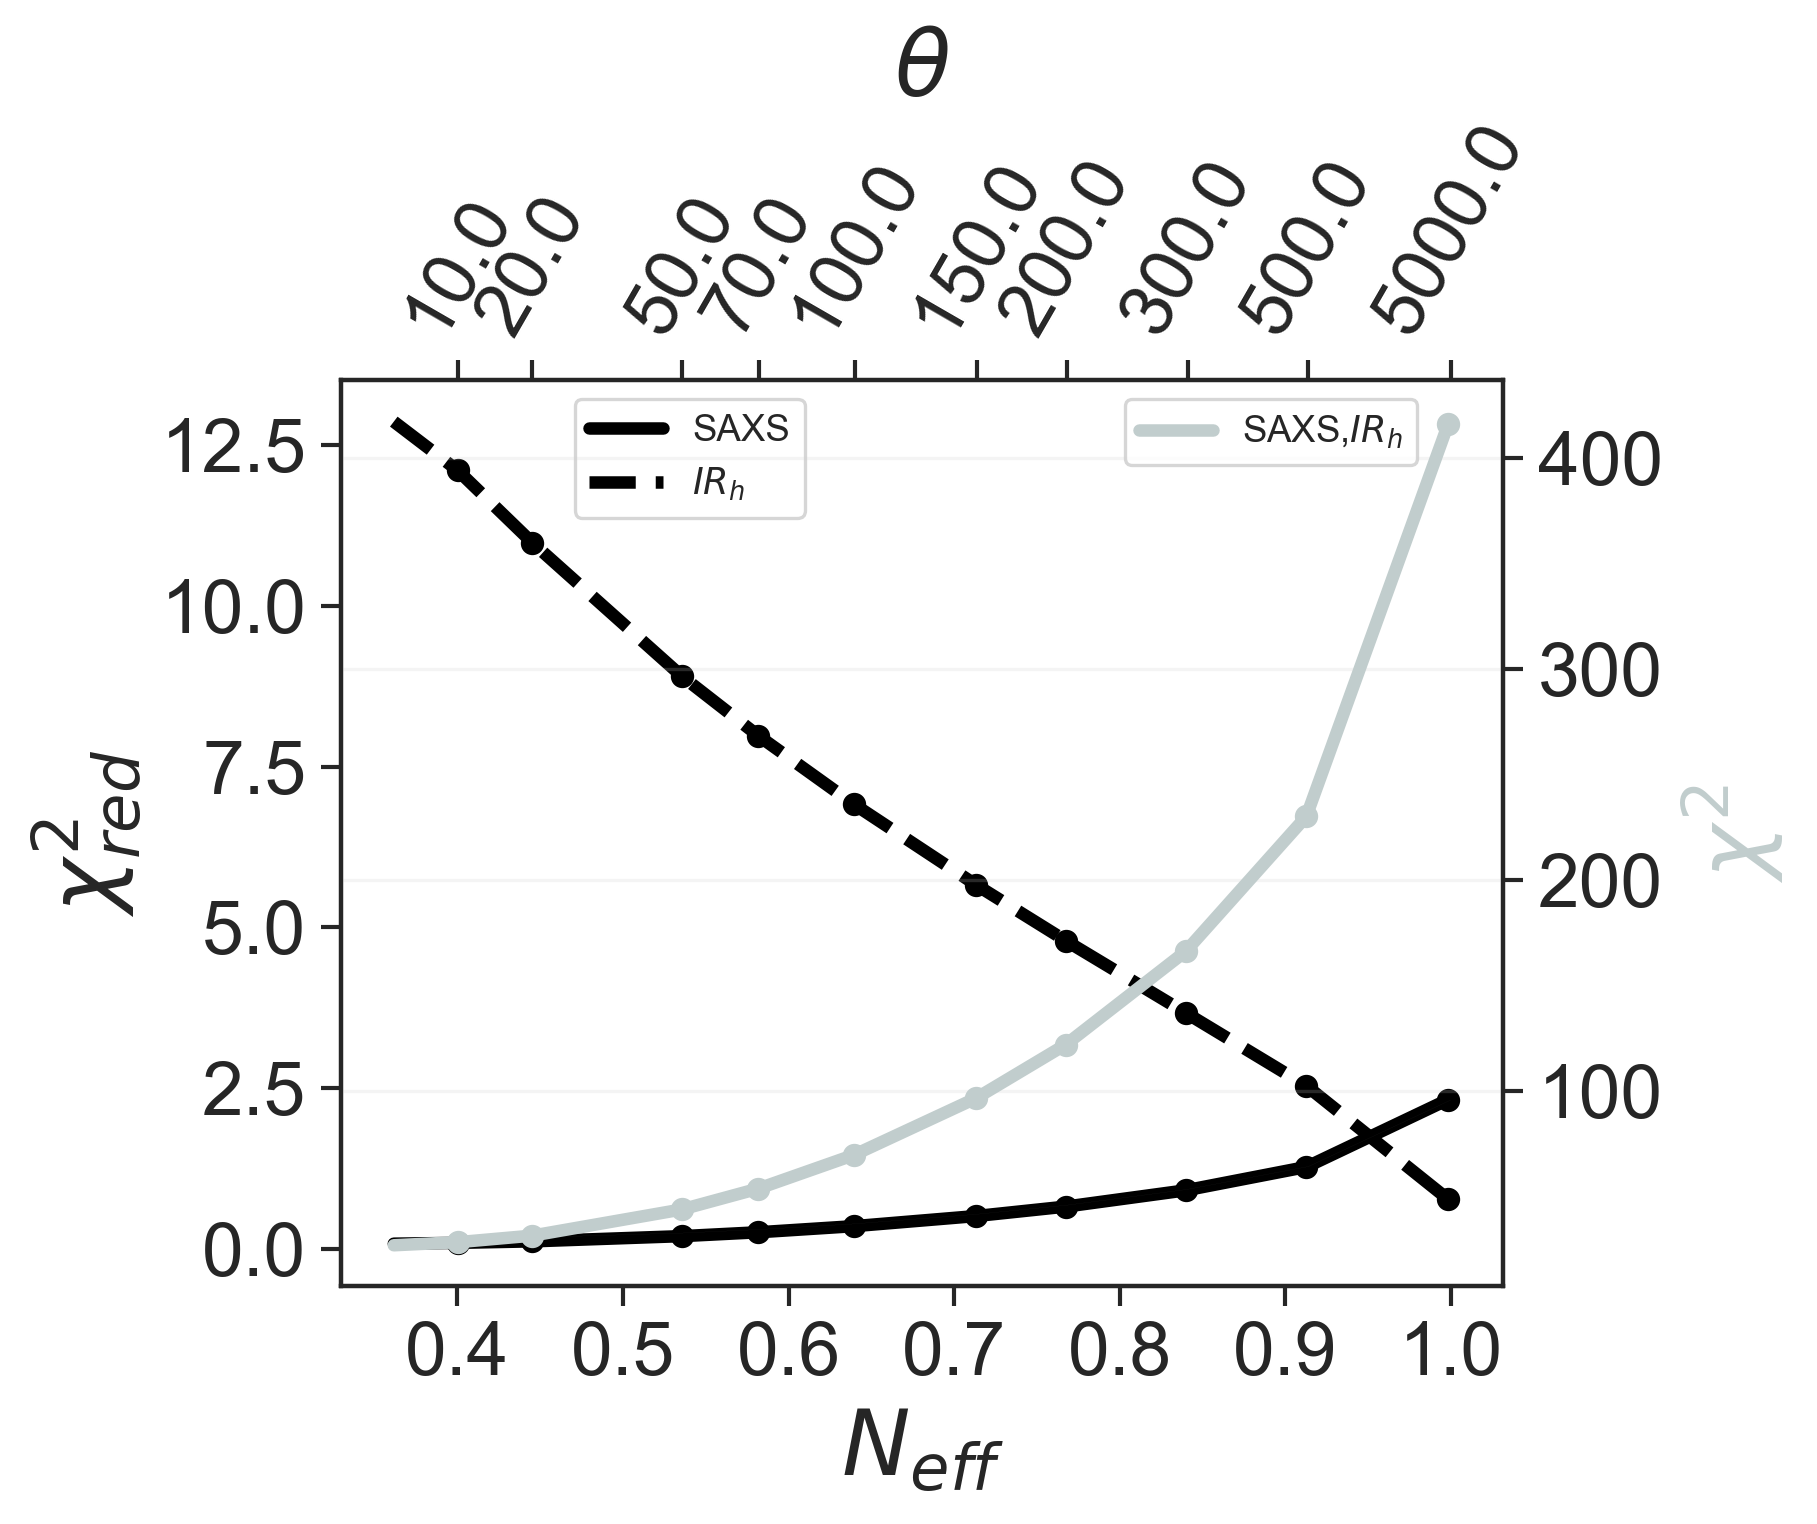

In [9]:
### Plot figure for different values of theta vs Neff and chi^2
sns.set_style("white")
sns.set_context("paper")

# handling tickers and read data
from matplotlib.ticker import NullFormatter
from matplotlib import ticker
import matplotlib as mpl
mpl.rcParams['figure.dpi'] =300
results = np.array(results)
# define the figure
fig, ax1 = plt.subplots(1,1,figsize=(5, 4))

# plot SAXS and IRh
ax1.plot(results[:,0],results[:,6],label="SAXS",c='k',ls="-",lw=3)
ax1.plot(results[:,0],results[:,4],label="$IR_h$",c='k',ls="--",lw=3)

# set tickers
ax1.set_xticks([0,0.1,0.2,0.3,0.4,0.5,.6,0.7,0.8,0.9,1.0])
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter("%3.1f"))
ax1.xaxis.set_minor_formatter(ticker.NullFormatter())

# Make a new horizontal axis to show the theta values and a new vertical axis to show the chi^2 total
ax2 = ax1.twiny()
ax2.plot(results[:,0],results[:,2],c='grey',lw=0.01)
ax3 = ax1.twinx()
ax3.plot(results[:,0],results[:,2]*180,label="SAXS,$IR_h$",c='#C1CDCD',lw=3)

#draw ticks at selected theta
sele = [10.,20.,50.,70.,100.,150.,200.,300.,500.,5000.]
iis = [thetas.index(s) for s in  sele]
ax2.set_xticks(results[iis,0])
ax2.set_xticklabels(["%.1f"% s for s in sele],rotation=60)
ax1.scatter(results[iis,0],results[iis,4],c='k')
ax1.scatter(results[iis,0],results[iis,6],c='k')
ax3.scatter(results[iis,0],results[iis,2]*180,c='#C1CDCD')

ax2.xaxis.set_minor_locator(ticker.MultipleLocator(5))

ax3.xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax3.set_ylabel(r"$\chi^2$", color='#C1CDCD',fontsize=22)
ax1.set_xlabel("$N_{eff}$",fontsize=22)
ax2.set_xlabel(r"$\theta$",fontsize=22)
ax1.set_ylabel(r"$\chi^2_{red}$",fontsize=22)
ax1.tick_params(axis='both', labelsize=18)
ax2.tick_params(axis='both', labelsize=18)
ax3.tick_params(axis='both', labelsize=18)
plt.grid(alpha=0.2)
ax1.legend(loc='upper center',bbox_to_anchor=(0.3, 0.5, 0.0, 0.5))
ax3.legend(loc='upper center',bbox_to_anchor=(0.5, 0.5, 0.6, 0.5))
plt.show()

Based on the L-curve plot above(grey), one would choose the elbow region as an optimal $\theta$. The elbow region is where further decrease in $\theta$  will not result in significant decrease in the associated $\chi^2$.  Here a $\theta$ between $70$ to $200$ will suffice. In our example we have used $\theta=100$. 

after choosing a theta we can look at how  $\chi^{2}_{re}$  lower after the reweighting:

In [10]:
# selected theta=150
chi2_before,chi2_after, srel = rew.optimize(theta=100)

print("# CHI2_re before minimization:     {:8.4f}".format(chi2_before))
print("# CHI2_re after minimization:      {:8.4f}".format(chi2_after))
print("# Fraction of effective frames:    {:8.4f}".format(np.exp(srel)))

# exp data: (180, 2)
# calc data: (32000, 180)
# CHI2_re before minimization:       2.4954
# CHI2_re after minimization:        0.3870
# Fraction of effective frames:      0.6395


The $\chi^2_{re}$ drops from 2.24 to 0.38 after rewighting with $\theta=100$. We are also effectively using ~63 % of the initial frames . 

Now that we have new weights it is very easy to calculate any average/distribution of interest.

We now plot the distribution Rg and Rh after and before reweighting using $\theta=1000$. 
but first start by block averaging the data. We do this to estimate the error, and also get an indication of the convergence of the observable we are calculating:


In [11]:
##### Block averaging and plot figure   

### Set bins for block average and optimal theta to use
n_frames = len(Rg)
n_bins =5
bin_size = n_frames//n_bins
bins = np.arange(0,n_frames+bin_size,bin_size)
theta=100


### split in 5 blocks
for j in range(len(bins)-1):

    rows = np.arange(bins[j],bins[j+1])
    rew = bme.Reweight()
    rew.load(exp_saxs,calc_saxs,rows=rows)
    rew.load(exp_Irh,calc_Irh,rows=rows)
    rew.optimize(theta=theta)
    
    rew.weight_exp(exp_saxs,calc_saxs, 'example2_{}_'.format(j),rows=rows)

    w_opt = rew.get_weights()

    ### write weights to file
    w0 = [1./len(w_opt)]*len(w_opt)
    string = "".join([ "{:10.4e} {:10.4e} \n ".format(w0[k],
                            w_opt[k])for k in range(len(w_opt))])
    fh = open("example2_{}_weights.dat" .format(j),"w")
    fh.write(string)
    fh.close()


# exp data: (180, 2)
# calc data: (6400, 180)
# exp data: (180, 2)
# calc data: (6400, 180)
# exp data: (180, 2)
# calc data: (6400, 180)
# exp data: (180, 2)
# calc data: (6400, 180)
# exp data: (180, 2)
# calc data: (6400, 180)


### We now plot the Rg and Rh distrubutions. 

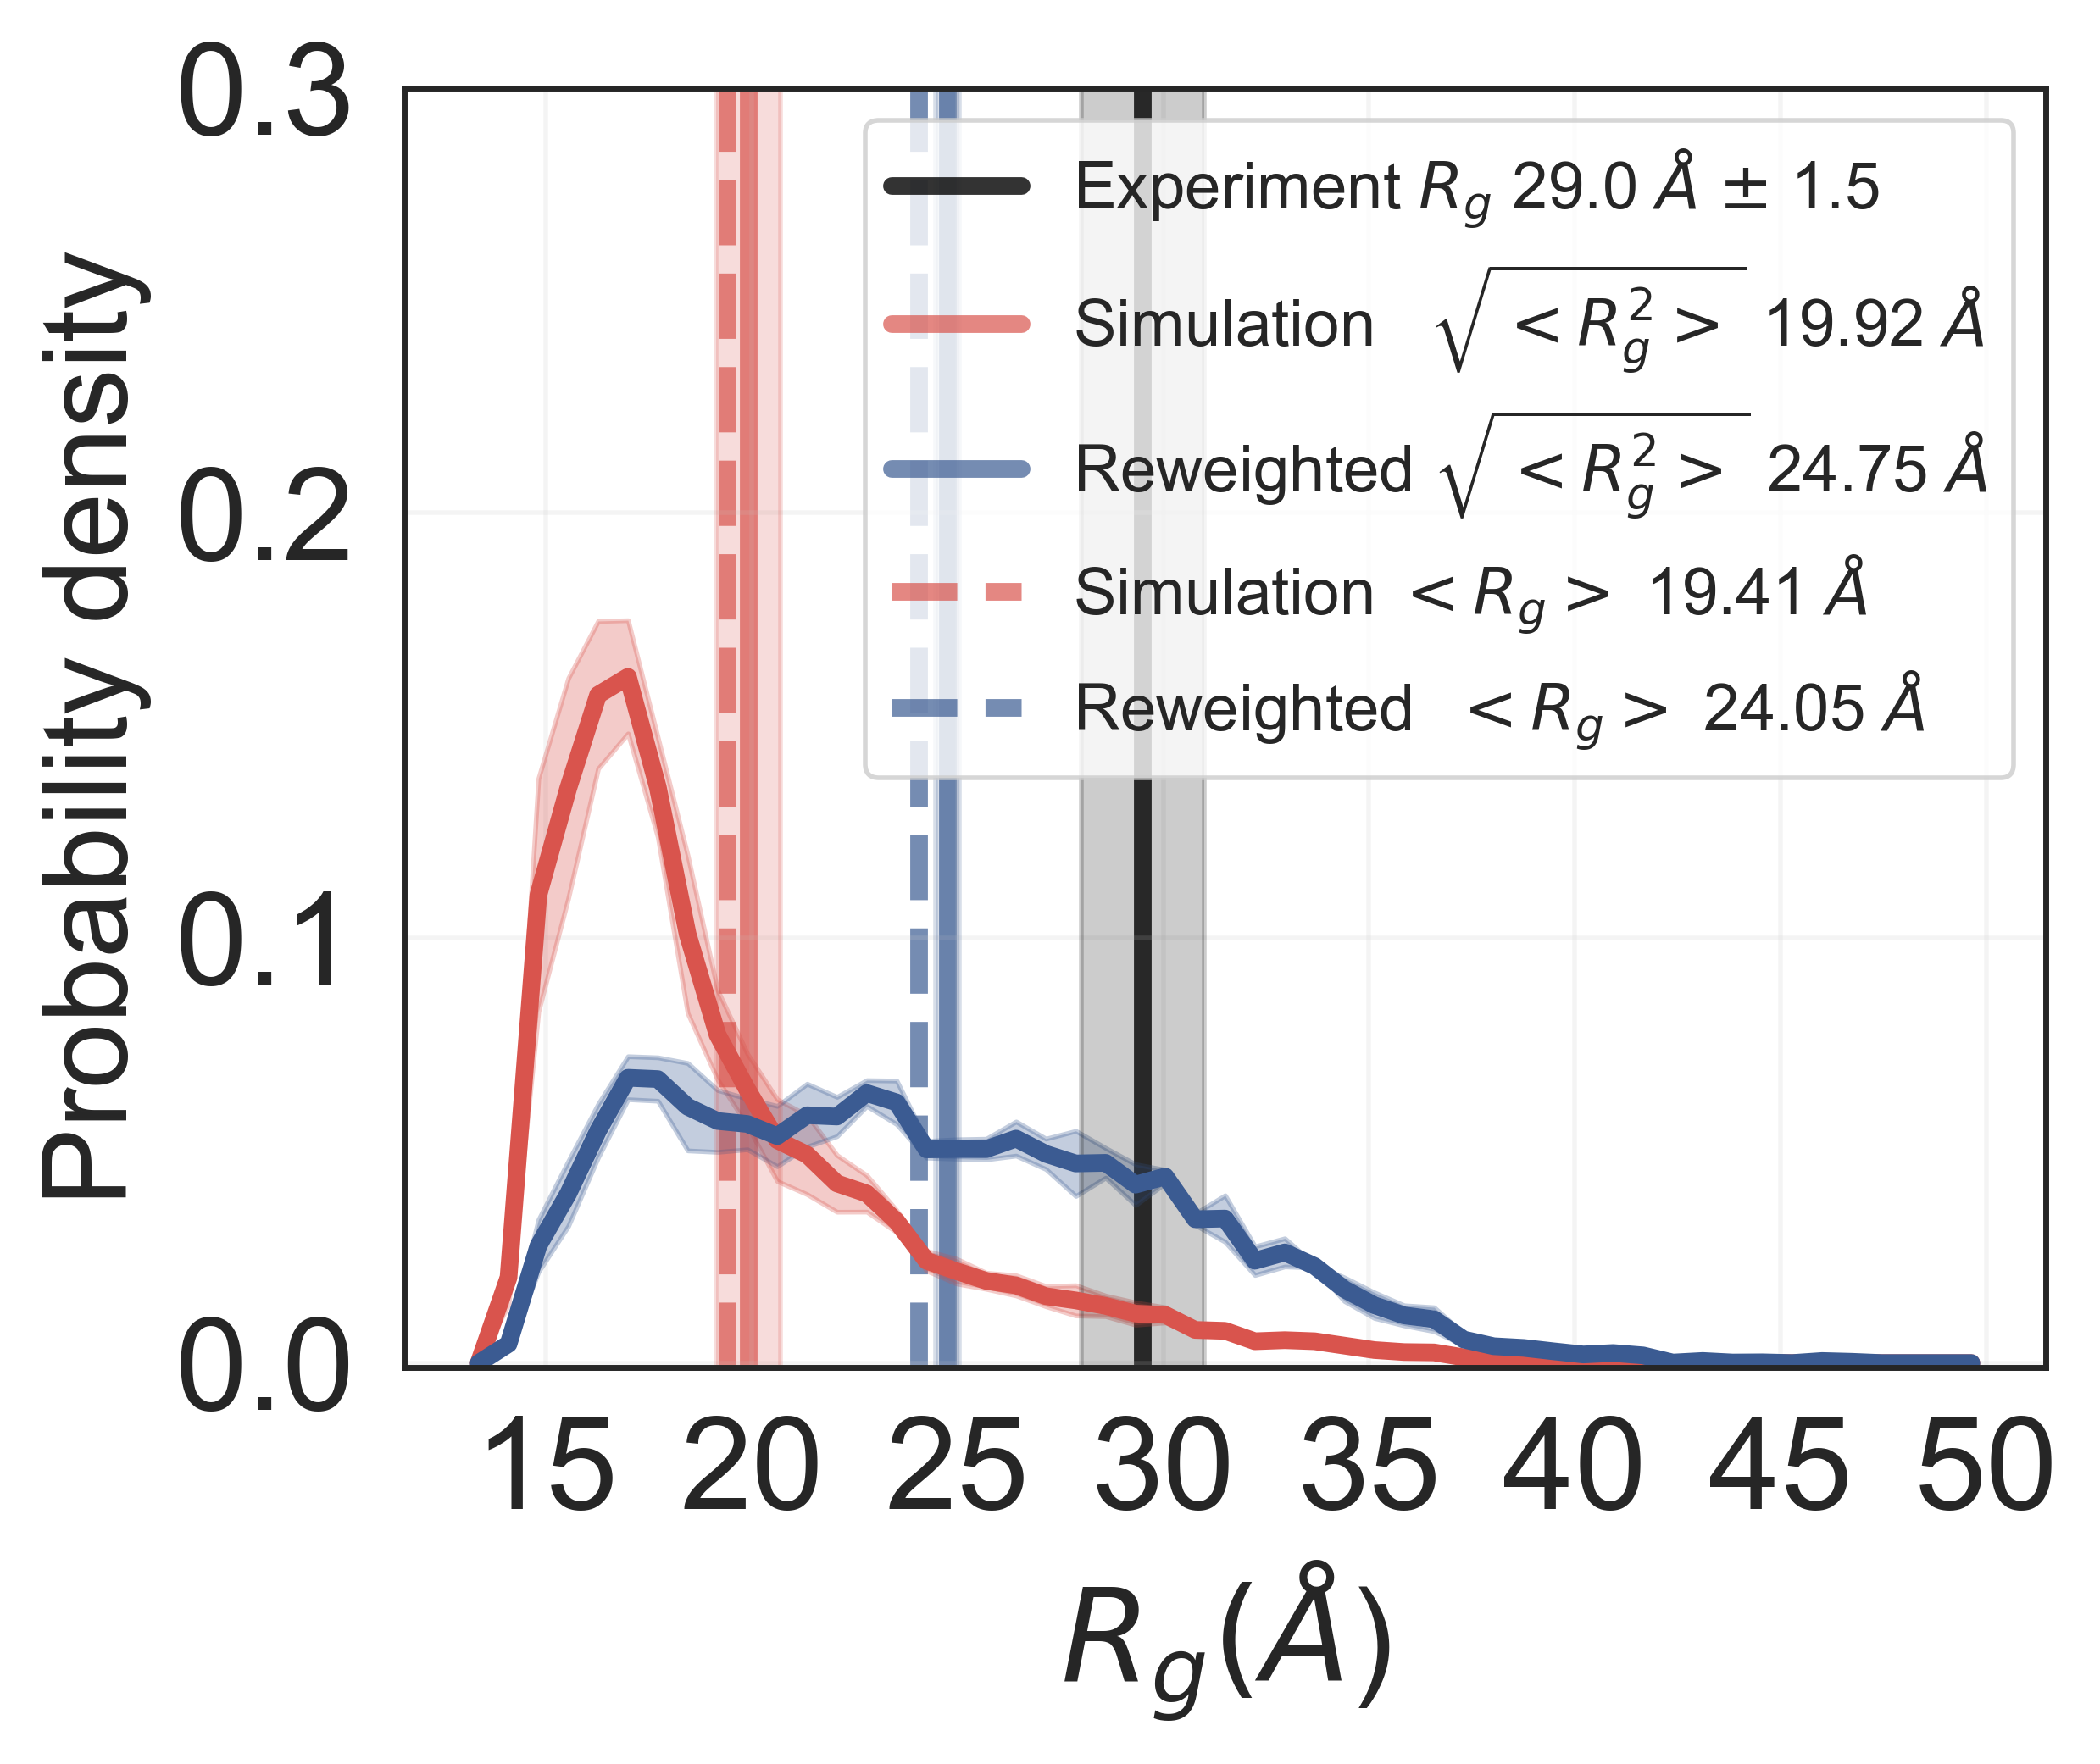

In [12]:
# We first load the data

data = Rg*Rg
data1 = Rg

# Set the figure style
sns.set_style("white")
sns.set_context("paper")
mpl.rcParams['figure.dpi'] = 500
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax.set_ylabel("Probability density",fontsize=20)
ax.set_xlabel("$R_g (\AA$)",fontsize=22)
ax.tick_params(axis='both', labelsize=22)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
c1 = sns.xkcd_rgb["black"]
c2 = sns.xkcd_rgb["pale red"]
c3 = sns.xkcd_rgb["denim blue"]


hist_0 = []
hist_post = []
binsize = n_frames//n_bins
sqrt_nbins = 1./np.sqrt(n_bins)
meanRgaa=[]
meanRga=[]
meanRgb=[]
bins = np.linspace(13,50,52)

for j in range(n_bins):
    
    # read weights
    weights = np.loadtxt('example2_{}_weights.dat'.format(j), usecols=1)
    Rgb = np.sqrt(np.mean(data[j*binsize:(j+1)*binsize]))
    Rga = np.sqrt(np.sum(weights*data[j*binsize:(j+1)*binsize]))
    Rgaa =(np.sum(weights*data1[j*binsize:(j+1)*binsize]))
    meanRgb.append(Rgb)
    meanRga.append(Rga)
    meanRgaa.append(Rgaa)
    hh_0, ee_0 = np.histogram(np.sqrt(data[j*binsize:(j+1)*binsize]),density=True,bins=bins)
    hist_0.append(hh_0)
    hh_post, ee_1 = np.histogram(np.sqrt(data[j*binsize:(j+1)*binsize]),density=True,bins=bins,weights=weights)
    hist_post.append(hh_post)

    
# plot   
xx = 0.5*(ee_0[1:]+ee_0[:-1])
avg_0 = np.average(hist_0,axis=0)
sem_0 = sqrt_nbins*np.std(hist_0,axis=0,ddof=1)
ax.plot(xx,avg_0,color=c2,ls='-',lw=3)
ax.fill_between(xx,avg_0-sem_0,avg_0+sem_0,color=c2,alpha=0.3)
avg_post = np.average(hist_post,axis=0)
sem_post = sqrt_nbins*np.std(hist_post,axis=0,ddof=1)
ax.plot(xx,avg_post,color=c3,ls='-',lw=3)

ax.fill_between(xx,avg_post-sem_post,avg_post+sem_post,color=c3,alpha=0.3)

ax.axvspan(Rg_Exp.nominal_value-Rg_Exp.std_dev,Rg_Exp.nominal_value+Rg_Exp.std_dev, alpha=0.2, color=c1)
plt.axvline(Rg_Exp.nominal_value,ls='-',color=c1,alpha=0.8,lw=3,
            zorder=0,label='Experiment $R_g$ 29.0 $\AA$ $\pm$ 1.5' )

ax.axvspan(np.mean(meanRgb)-np.std(meanRgb),np.mean(meanRgb)+np.std(meanRgb), 
           alpha=0.2, color=c2)
ax.axvspan(np.mean(meanRga)-np.std(meanRga),np.mean(meanRga)+np.std(meanRga), 
           alpha=0.2, color=c3)

plt.axvline(np.round(np.mean(meanRgb),decimals=2),ls='-',
            c=c2,alpha=0.7,lw=3,zorder=0,label='Simulation   $\sqrt{<R_g^2>}$ ' + 
             np.str(np.round(np.mean(meanRgb),decimals=2))+ ' $\AA$')
plt.axvline(np.round(np.mean(meanRga),decimals=2),ls='-',
            color=c3,alpha=0.7,lw=3,zorder=0,label='Reweighted $\sqrt{<R_g^2>}$ '+ 
             np.str(np.round(np.mean(meanRga),decimals=2))+ ' $\AA$')
plt.axvline(np.round(np.mean(data1),decimals=2),ls='--',
            color=c2,alpha=0.7,lw=3,zorder=0,label='Simulation $<R_g>$ '+ 
             np.str(np.round(np.mean(data1),decimals=2))+ ' $\AA$')

plt.axvline(np.round(np.mean((meanRgaa)),decimals=2),ls='--',
            color=c3,alpha=0.7,lw=3,zorder=0,label='Reweighted  $<R_g>$ '+ 
             np.str(np.round(np.mean((meanRgaa)),decimals=2))+ ' $\AA$')
plt.ylim(-0.001,0.3)
plt.grid(alpha=0.2)
ax.legend(markerscale=1,prop={'size': 11})
plt.show()



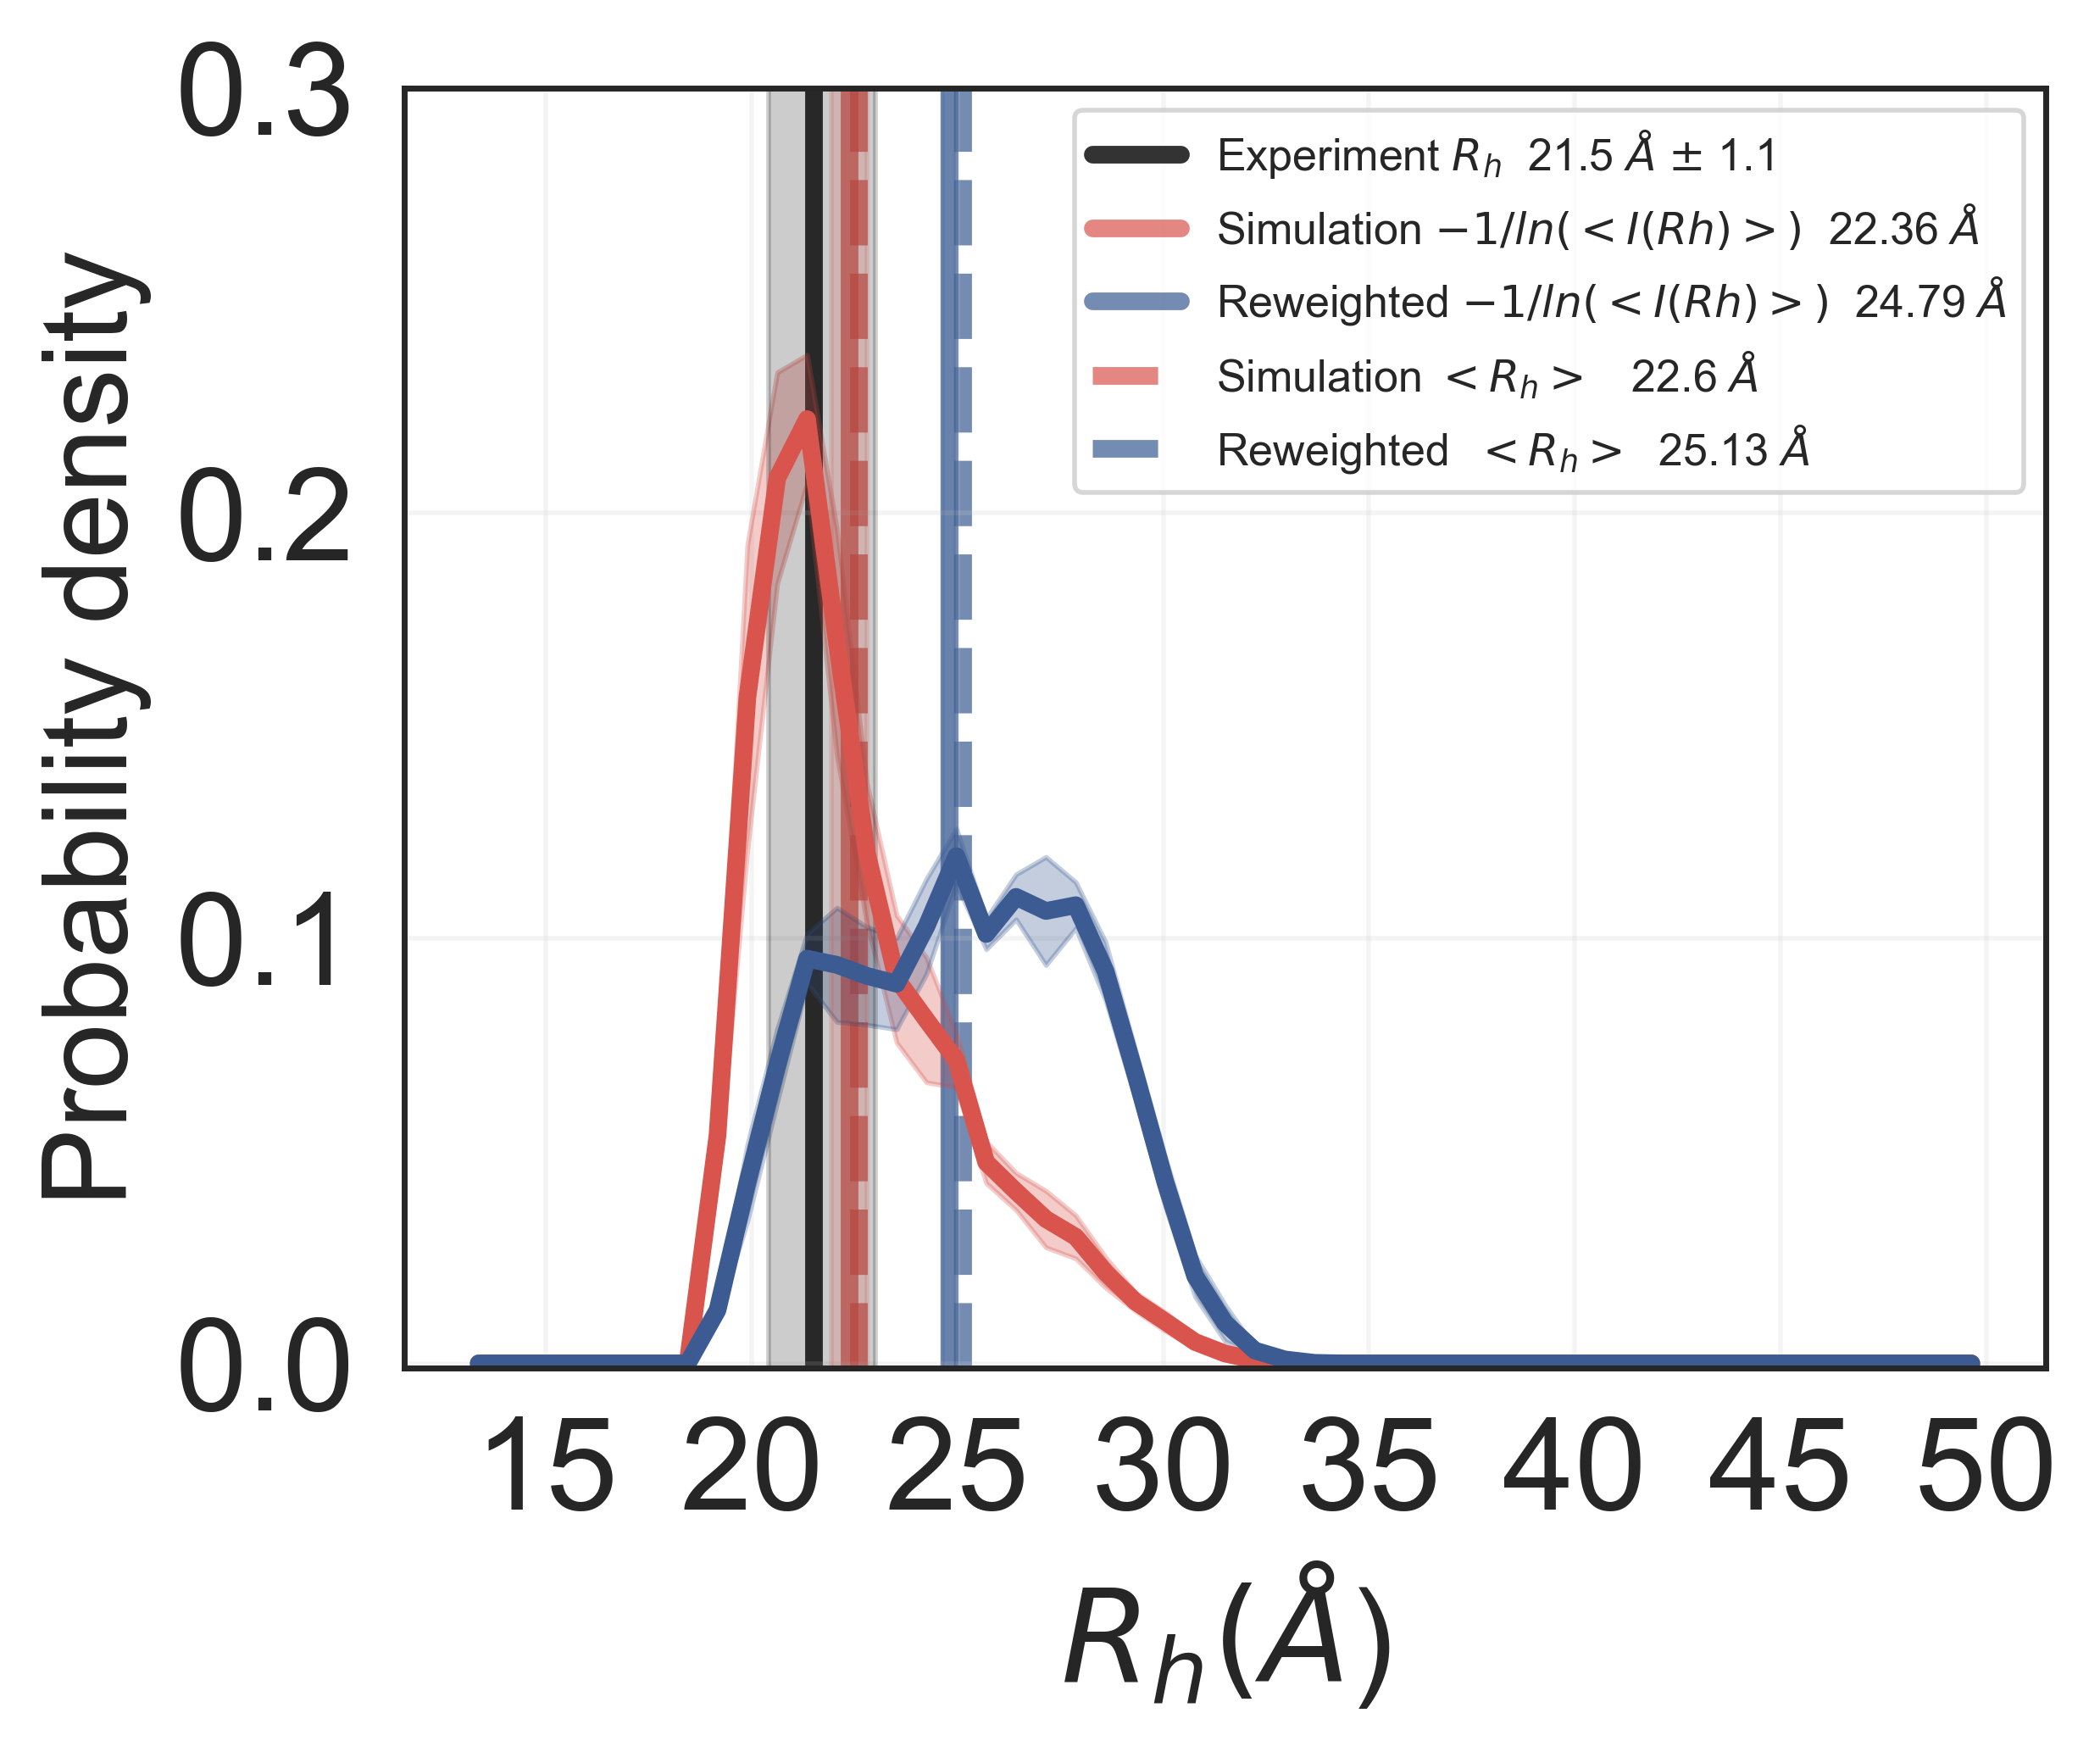

In [13]:
# load data
data2 =  I_Rh
data3 = Rh

sns.set_style("white")
sns.set_context("paper")
mpl.rcParams['figure.dpi'] = 500

fig,ax = plt.subplots(1,1,figsize=(5,4))
ax.set_ylabel("Probability density",fontsize=20)
ax.set_xlabel("$R_h (\AA$)",fontsize=22)
ax.tick_params(axis='both', labelsize=22)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
c1 = sns.xkcd_rgb["black"]
c2 = sns.xkcd_rgb["pale red"]
c3 = sns.xkcd_rgb["denim blue"]
hist_0 = []
hist_post = []
binsize = n_frames//n_bins
sqrt_nbins = 1./np.sqrt(n_bins)
meanRgab=[]
meanRga=[]
meanRgb=[]
bins = np.linspace(13,50,52)


for j in range(n_bins):
    # read weights
    weights = np.loadtxt('example2_{}_weights.dat'.format(j), usecols=1)
    Rgb = -1./np.log((np.mean(data2[j*binsize:(j+1)*binsize])))
    Rga =-1/np.log((np.sum(weights*data2[j*binsize:(j+1)*binsize])))
    Rgab =(np.sum(weights*data3[j*binsize:(j+1)*binsize]))
    meanRgb.append(Rgb)
    meanRga.append(Rga)
    meanRgab.append(Rgab)
    hh_0, ee_0 = np.histogram(data3[j*binsize:(j+1)*binsize],density=True,bins=bins)
    hist_0.append(hh_0)
    hh_post, ee_1 = np.histogram(data3[j*binsize:(j+1)*binsize],density=True,bins=bins,weights=weights)    
    hist_post.append(hh_post)
    
#plot
xx = 0.5*(ee_0[1:]+ee_0[:-1])
avg_0 = np.average(hist_0,axis=0)
sem_0 = sqrt_nbins*np.std(hist_0,axis=0,ddof=1)
ax.plot(xx,avg_0,color=c2,ls='-', lw=3)
ax.fill_between(xx,avg_0-sem_0,avg_0+sem_0,color=c2,alpha=0.3)
avg_post = np.average(hist_post,axis=0)
sem_post = sqrt_nbins*np.std(hist_post,axis=0,ddof=1)
ax.plot(xx,avg_post,color=c3,ls='-', lw=3)
ax.fill_between(xx,avg_post-sem_post,avg_post+sem_post,color=c3,alpha=0.3)

ax.axvspan(Rh_Exp.nominal_value-Rh_Exp.std_dev,Rh_Exp.nominal_value+Rg_Exp.std_dev, alpha=0.2, color=c1)
plt.axvline(Rh_Exp.nominal_value,ls='-',color=c1,alpha=0.8,lw=3,zorder=0,label='Experiment $R_h$  21.5 $\AA$ $\pm$ 1.1' )
ax.axvspan(np.mean(meanRgb)-np.std(meanRgb),np.mean(meanRgb)+np.std(meanRgb), alpha=0.2, color=c2)
ax.axvspan(np.mean(meanRga)-np.std(meanRga),np.mean(meanRga)+np.std(meanRga), alpha=0.2, color=c3)

plt.axvline(np.round(np.mean(meanRgb),decimals=2),ls='-',c=c2,alpha=0.7,lw=3,zorder=0,label='Simulation $-1/ln(<I(Rh)>)$  ' + 
             np.str(np.round(np.mean(meanRgb),decimals=2))+ ' $\AA$')
plt.axvline(np.round(np.mean(meanRga),decimals=2),ls='-',color=c3,alpha=0.7,lw=3,zorder=0,label='Reweighted $-1/ln(<I(Rh)>)$  '+ 
             np.str(np.round(np.mean(meanRga),decimals=2))+ ' $\AA$')

plt.axvline(np.round(np.mean(data3),decimals=2),ls='--',
            color=c2,alpha=0.7,lw=3,zorder=0,label='Simulation $<R_h>$   '+ 
             np.str(np.round(np.mean(data3),decimals=2))+ ' $\AA$')

plt.axvline(np.round(np.mean((meanRgab)),decimals=2),ls='--',
            color=c3,alpha=0.7,lw=3,zorder=0,label='Reweighted  $<R_h>$  '+ 
             np.str(np.round(np.mean((meanRgab)),decimals=2))+ ' $\AA$')
plt.ylim(-0.001,0.3)
plt.grid(alpha=0.2)
plt.legend( prop={'size': 7.5})
plt.show()



We now plot the calculated SAXS intensity before and after the reweight in comparson with the experimental saxs curve. We load the saved SAXS curve before and and after in the reweighting step(file `example2_0_.stats.dat`) and plot:

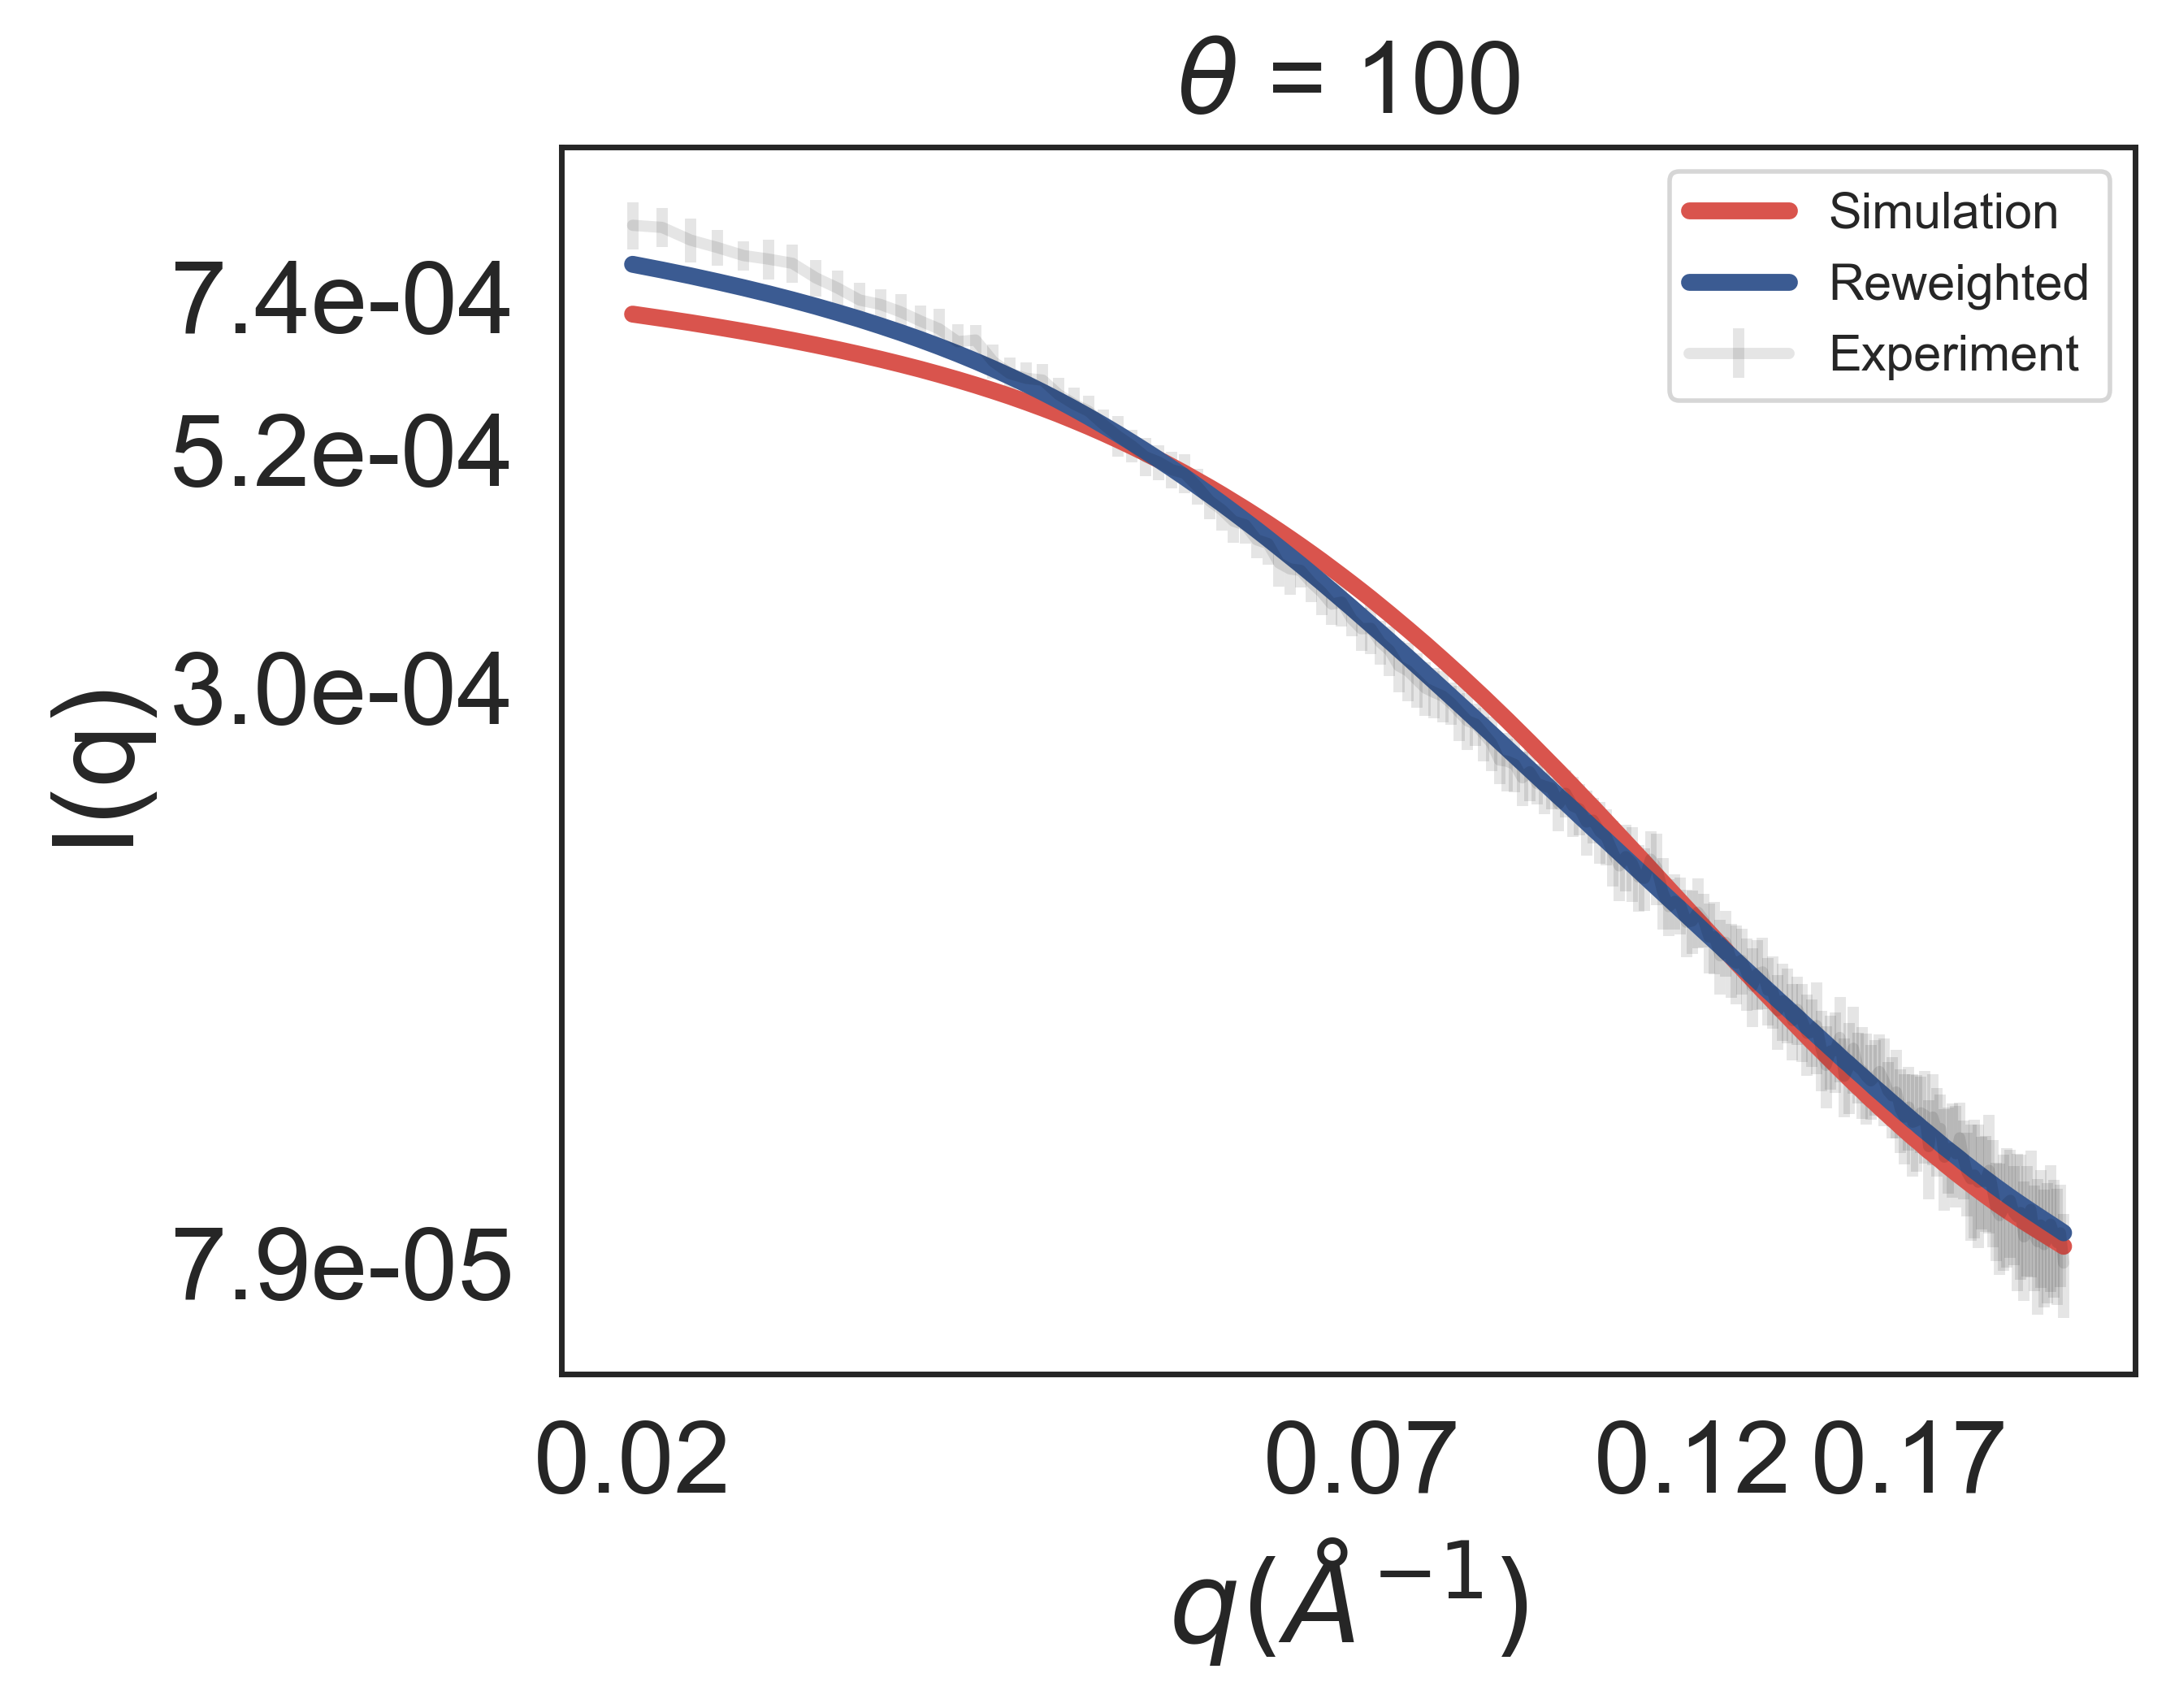

In [16]:
### load SAXS profiles saved by BME

sxs = np.loadtxt("example2_0_.stats.dat");

## plot figure
mpl.rcParams['figure.dpi'] =500


fig,ax = plt.subplots(1,1,figsize=(5,4))
plt.loglog()

from matplotlib.ticker import FormatStrFormatter 
ax.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1e"))
ax.minorticks_off()
ax.set_xticks(np.arange(min(sxs[:,0]),max(sxs[:,0]), 0.05))
ax.set_yticks(np.arange(min(sxs[:,1]),max(sxs[:,1]), 0.00022),)

ax.errorbar(sxs[:,0],sxs[:,1],yerr=sxs[:,2],alpha=0.1,label="Experiment", c=c1,lw=2)
ax.plot(sxs[:,0],sxs[:,3],label="Simulation",c=c2,lw=3 )
ax.plot(sxs[:,0],sxs[:,4],label="Reweighted" ,c=c3,lw=3)
ax.set_title(r"$\theta$ = " + np.str(theta), fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_xlabel("$q (\AA^{-1})$",fontsize=20)

ax.set_ylabel("I(q)",fontsize=20)
plt.legend()
plt.show()


#  5 Runing and setting the parameters for Pepsi-SAXS

Pepsi-SAXS is run as simple command-line tool e.g: `Pepsi-SAXS [pdb file] [experimental curve] -o [output file]`. The input files required are a `pdb file` and a `experimental SAXS data file`. However, Pepsi-SAXS only takes one structure(pdb file) at a time, thus for an ensemble containing multiple structures, one has to make the above command iterative.  The code below iterativly run through all the frames(pdb files) in the ensemble, while also automatically setting the two fitting parameters $\delta r$  (`--r0_min_factor` and `--r0_max_factor` ) and $\delta \rho$ (`--dro`) for the ensemble.  

Before running the code the user should remember to set the correct path to Pepsi-SAXS and the input files, while also be aware of the naming of the input files. 

### Other useful flags
`-ns` : Number of data points to use in the calculation if experimental data is not provided.

`-ms` : Maximum scattering vector to use in the calculation in inverse Angstroms.

`-cst` : Substract a constant factor if experimental data contains a systematic error.



In [ ]:
import subprocess
import os
import sys
import numpy as np

Pepsi_path = 'software/Pepsi-SAXS-SANS/Pepsi-SAXS' #Path to Pepsi-SAXS 
SAXS_data = 'exp.dat'                              #Path to Experimental SAXS file

# Load the frames in correct order
nr_of_frames = 0
for _, _, files in os.walk('.'):
        for file in files:
                if file.startswith('frame') and file.endswith('.pdb'):
                        nr_of_frames += 1

###### Note pdb files should be named frame_i.pdb #####################                               
    
    
    
# First, fit all frames and all parameters
# Note we have set -ms 2 
step=1
if step==1:
        for i in range(0,nr_of_frames+1):
                filename = "frame_%d.pdb" % i
                outfile = "frame_%d.fit" % i
                subprocess.run([Pepsi_path, filename, SAXS_data , '-o '+  outfile, '-ms ' +' 2' ,'-cst' ,'-json'])

#find default r0. 
subprocess.run([Pepsi_path, 'frame_10.pdb', SAXS_data , '-o find_r0.fit', '-ms ' +' 2', '--r0_min_factor 1.0', '--r0_max_factor 1.0', '--r0_N 1', '-cst', '-json'])
with open('find_r0.log', 'r') as f:
        lines = f.readlines()
co=0
for line in lines:
        if "Best r0 found" in line:
                co+=1 #1
        if co==1 and "value" in line:
                co+=1 #2
                default_r0=float(line.split('"')[3])


#then, parse all the log files to find min/max r0 factors and best d_rho
print('parsing', nr_of_frames+1, 'log files')
r0_list = []
d_rho_list = []
#print (d_rho_list)
c=0
for i in range(0,nr_of_frames+1):
        filename = "frame_%d.log" % i
        try:
                with open(filename, 'r') as f:
                        lines = f.readlines()
                for line in lines:
                        if "Best d_rho found" in line:
                                c+=1 #1
                        if c==1 and "value" in line:
                                c+=1 #2
                                value=float(line.split('"')[3])
                                d_rho_list.append(value)
                        if "Best r0 found" in line:
                                c+=1 #3
                        if c==3 and "value" in line:
                                c+=1 #4
                                value=float(line.split('"')[3])/default_r0
                                r0_list.append(value)
        except:
                print(filename, 'not found, skipping it.')




#Take the average to find ensemble min/max r0 factors and d_rho
r0 = str(np.average(r0_list))
d_rho = str(np.average(d_rho_list)*10)



#refit all of the frames, using the ensemble parameters
for i in range(0,nr_of_frames+1):
        filename = "frame_%d.pdb" % i
        outfile = "Ave_AA_frame%d.fit" % i
        subprocess.run([Pepsi_path, filename, SAXS_data , '-o ' + outfile, '--dro ' + d_rho, '-ms ' +' 2', '--r0_min_factor '+ r0, '--r0_max_factor '+ r0, '--r0_N 1', '-cst'])

print('ensemble d_rho', d_rho)
print('ensemble r0', r0)
print('default r0', default_r0)
print('done')